<a href="https://colab.research.google.com/github/7jeon8gi/BigData_hyu/blob/master/BIG_term_project_6_11_%EC%88%98%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 빅데이터 마이닝 term project
#### 수학과 지수련, 경제금융학부 김남형

## 서울시 공공자전거
###아래의 데이터를 활용하였음

#### 1. 서울특별시 공공자전거 대여소 정보 http://data.seoul.go.kr/dataList/datasetView.do?infId=OA-13252&srvType=S&serviceKind=1&currentPageNo=1

#### 2. 서울시 공공자전거 이용 현황 http://data.seoul.go.kr/dataList/datasetView.do?infId=OA-14994&srvType=S&serviceKind=1&currentPageNo=1&searchValue=&searchKey=null

#### 필요한 library 입력

In [0]:
# module import
import keras
import folium
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import requests
import datetime
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


#### API를 통한 '서울특별시 공공자전거 대여소 정보' Data 수집

In [0]:
url_format="http://openapi.seoul.go.kr:8088/{api_key}/json/{api_name}/1/{end_index}"
api_key="4766464f6867693836337476594649"

class Seoul():
 
  def __init__(self):
    self.url_format = "http://openapi.seoul.go.kr:8088/{api_key}/json/{api_name}/{start_index}/{end_index}"
    self.api_key ="7446456c5067693833354275636c62"
  
  def get(self):
    
    #http://openapi.seoul.go.kr:8088/4766464f6867693836337476594649/json/bikeList/1/1000/
    
    url="http://openapi.seoul.go.kr:8088/4766464f6867693836337476594649/json/bikeList/1/1000/"
    response=requests.get(url).json()
    result=pd.DataFrame(response["rentBikeStatus"]["row"])
    
    url1="http://openapi.seoul.go.kr:8088/4766464f6867693836337476594649/json/bikeList/1001/2000/"
    response1=requests.get(url1).json()
    result1=pd.DataFrame(response1["rentBikeStatus"]["row"])
    
    result=pd.concat([result,result1])
    
    return result
    
  def get2(self,api_name,api_key=api_key,start_index=None,end_index=None):
    #http://openapi.seoul.go.kr:8088/(인증키)/xml/TB_PUBLIC_BCYCL_LEND_USE/1/5/
    
    url=self.url_format.format(api_name=api_name,api_key=api_key,start_index=1, end_index=1)
    re = requests.get(url).json()
    end_index1 = re[api_name]["list_total_count"]
    print("Max Count(%s)"%(end_index1))
    
    if end_index1>1000: #..........
      count=1
      result=pd.DataFrame()
      while count < end_index1:
        url=self.url_format.format(api_name=api_name,api_key=api_key,start_index=count, end_index=count+999)
        response1 = requests.get(url).json()
        result1=pd.DataFrame(response1[api_name]["row"])
        result=pd.concat([result,result1])
        count+=1000
        print(count,end=' ')
        
    elif end_index1<1000: 
      url=self.url_format.format(api_name=api_name,api_key=api_key,start_index=1, end_index=1000)
      response1 = requests.get(url).json()
      result=pd.DataFrame(response1[api_name]["row"])
      
    return result

  def get3(self,api_name,api_key=api_key,start_index=None,end_index=None,sub_key=None):
    result=pd.DataFrame()
    url=self.url_format.format(api_name=api_name,api_key=api_key,start_index=1, end_index=1)
    url=url+"/"+str(sub_key)
    print(url)
    response1 = requests.get(url).json()
    try:
      result=pd.DataFrame(response1[api_name]["row"])
    except KeyError:
      pass
    return result
  
Big=Seoul()

In [0]:
Big=Seoul()
rental_info=Big.get2(api_name="PublicBicycleRenTIdinfo")
print("lenght is %s"%len(rental_info))
rental_info = rental_info.reset_index(drop=True)
rental_info.columns=['ADDR_GU	','CONTENT_ID','CONTENT_NM','CRADLE_COUNT','LATITUDE','LONGITUDE','NEW_ADDR','RENT_ID']
rental_info.head()

Max Count(1460)
1001 2001 lenght is 1460


,ADDR_GU,CONTENT_ID,CONTENT_NM,CRADLE_COUNT,LATITUDE,LONGITUDE,NEW_ADDR,RENT_ID
0,강남구,2301,현대고등학교 건너편,10.0,37.524071,127.021790,서울특별시 강남구 압구정로 134현대고등학교 건너편,ST-777
1,강남구,2302,교보타워 버스정류장(신논현역 3번출구 후면),10.0,37.505581,127.024277,서울특별시 강남구 봉은사로 지하 102교보타워 버스정류장,ST-787
2,강남구,2303,논현역 7번출구,15.0,37.511517,127.021477,서울특별시 강남구 학동로 지하 102논현역 7번출구,ST-788
3,강남구,2304,신영 ROYAL PALACE 앞,10.0,37.512527,127.035835,서울특별시 강남구 언주로 626신영 ROYAL PALACE앞,ST-789
4,강남구,2305,MCM 본사 직영점 앞,10.0,37.520641,127.034508,서울특별시 강남구 언주로 734MCM 본사 직영점 앞,ST-790


In [0]:
#필요없는 필드 제거
rental_info=rental_info.drop(['CONTENT_NM','NEW_ADDR'],axis=1)

#CONTENT_ID를 integer로 변경
rental_info.CONTENT_ID=rental_info.CONTENT_ID.astype(int)

#### '서울시 공공자전거 이용 현황' csv 입력

In [0]:
# '서울시 공공자전거 이용 현황'의 경우 데이터가 커서 작업 효율이 떨어지므로(API는 한번에 1000개의 index만을 불러올 수 있음) 드롭박스를 이용하여 데이터를 업로드하였음.
use = pd.read_csv('https://www.dropbox.com/s/vyjfcbxn66eghd8/%EC%84%9C%EC%9A%B8%EC%8B%9C%20%EA%B3%B5%EA%B3%B5%EC%9E%90%EC%A0%84%EA%B1%B0%20%EC%9D%B4%EC%9A%A9%ED%98%84%ED%99%A9.csv?dl=1',header=0)
print("lenght is %s"%len(use))
use.columns=['ADDR_GU','CONTENT_ID','Date','rent_num','return_num']

#Date를 time series로 변경
use['Date'] = use['Date'].astype('datetime64[ns]')

#missing value
print(len(use[use["CONTENT_ID"]=="대여소명 없음"]))

lenght is 721661
1572


In [0]:
#remove missing value
use=use[use.CONTENT_ID != '대여소명 없음']

#필요없는 필드 제거
use=use.drop('ADDR_GU',axis=1)

#remove Korean to make CONTENT_ID integer
use['CONTENT_ID'] = use.CONTENT_ID.str.extract(r'(\d+)', expand=True).astype(int)

#### 데이터 통합 및 추가 작업

In [0]:
df=pd.merge(use,rental_info)
df= df.sort_values(["Date"],)
df= df.reset_index(drop=True)
df.head()

,CONTENT_ID,Date,rent_num,return_num,ADDR_GU,CRADLE_COUNT,LATITUDE,LONGITUDE,RENT_ID
0,201,2015-09-19,11,19,영등포구,15.0,37.531239,126.921333,ST-46
1,131,2015-09-19,5,7,서대문구,23.0,37.584171,126.911102,ST-33
2,124,2015-09-19,15,14,마포구,20.0,37.551140,126.936989,ST-26
3,135,2015-09-19,6,4,서대문구,10.0,37.559101,126.939178,ST-37
4,217,2015-09-19,9,6,영등포구,10.0,37.522079,126.930367,ST-66


#### Weekday 설정: 주중과 주말의 분할을 위함

In [0]:
df["day_of_the_week"]=df["Date"].dt.weekday_name
df.head()

,CONTENT_ID,Date,rent_num,return_num,ADDR_GU,CRADLE_COUNT,LATITUDE,LONGITUDE,RENT_ID,day_of_the_week
0,201,2015-09-19,11,19,영등포구,15.0,37.531239,126.921333,ST-46,Saturday
1,131,2015-09-19,5,7,서대문구,23.0,37.584171,126.911102,ST-33,Saturday
2,124,2015-09-19,15,14,마포구,20.0,37.551140,126.936989,ST-26,Saturday
3,135,2015-09-19,6,4,서대문구,10.0,37.559101,126.939178,ST-37,Saturday
4,217,2015-09-19,9,6,영등포구,10.0,37.522079,126.930367,ST-66,Saturday


In [0]:
weekday=['Monday','Tuesday','Wednesday','Thursday','Friday']
weekend=['Saturday','Sunday']

df_day=df[df['day_of_the_week'].isin(weekday)]
df_end=df[df['day_of_the_week'].isin(weekend)]

#### 주중 분석

In [0]:
# 참고: https://www.google.co.kr/search?ei=QLvjXMLVB5SVr7wPw9aJmAM&q=pandas+split+dataframe+by+column+value&oq=dataframe+by+column&gs_l=psy-ab.1.6.0i7i30l10.28357.28357..35639...0.0..0.135.135.0j1......0....1..gws-wiz.6ehkUs4eCeA
# CONTENT_ID의 value 값으로 1460길이의 dict(key:데이터프레임) 생성

list_of_df_day = [[g,x] for [g,x] in df_day.groupby(['CONTENT_ID'])] #CONTENT_ID도 저장
dictday=dict(list_of_df_day) #Dictionary

# CONTENT_ID 값들의 list
cont_id=df_day['CONTENT_ID'].drop_duplicates().values.tolist()

In [0]:
day_rent=list()
day_return=list()
for id in cont_id:
  
  a=datetime.date(dictday[id]["Date"].tolist()[0])
  b=datetime.date(dictday[id]["Date"].tolist()[-1])
  
  delta = b-a  
  #Data의 시작 날짜와 끝 날짜. 기간 중 신규 설치된 대여소는 delta 값이 다를 수 있음. ex)2301 번과 101번 대여소의 날짜는 서로 상이함.
  
  total_rent=dictday[id]["rent_num"].sum()
  mean_rent=total_rent/delta.days
  day_rent.append([id,mean_rent])
  
  total_return=dictday[id]["return_num"].sum()
  mean_return=total_return/delta.days
  day_return.append([id,mean_return])

In [0]:
A=pd.DataFrame(day_rent,columns=['CONTENT_ID','day_rent']) 
B=pd.DataFrame(day_return,columns=['CONTENT_ID','day_return'])
dfday=pd.merge(A,B)
rental=pd.merge(rental_info,dfday)

# day_rent 와 day_return 값은 평균 값임.

In [0]:
rental.head(10)

,ADDR_GU,CONTENT_ID,CRADLE_COUNT,LATITUDE,LONGITUDE,RENT_ID,day_rent,day_return
0,강남구,2301,10.0,37.524071,127.021790,ST-777,31.160681,32.551985
1,강남구,2302,10.0,37.505581,127.024277,ST-787,22.971645,22.519849
2,강남구,2303,15.0,37.511517,127.021477,ST-788,14.835417,13.239583
3,강남구,2304,10.0,37.512527,127.035835,ST-789,7.505792,3.084942
4,강남구,2305,10.0,37.520641,127.034508,ST-790,7.668651,8.226190
5,강남구,2306,30.0,37.527122,127.028717,ST-791,23.096525,18.758687
6,강남구,2307,10.0,37.528614,127.038559,ST-792,15.682510,15.642586
7,강남구,2308,14.0,37.529301,127.035599,ST-793,14.406427,14.068053
8,강남구,2309,10.0,37.518902,127.049385,ST-783,9.666041,5.831144
9,강남구,2310,10.0,37.523613,127.040176,ST-794,8.967742,8.505376


In [0]:
max(rental['day_rent'])

97.12271062271063

#### 시각화 작업

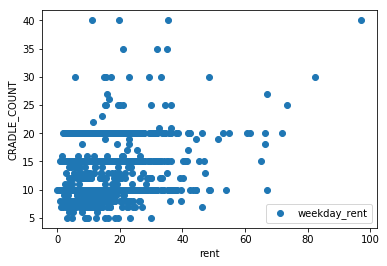

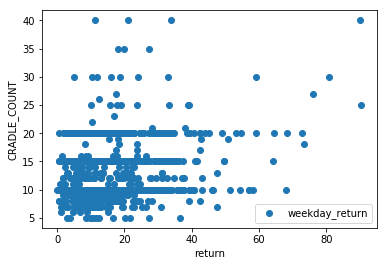

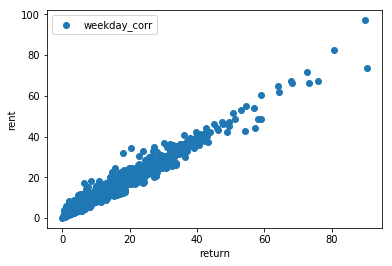

In [0]:
x=rental['day_rent']
y=rental['CRADLE_COUNT']

plt.figure(1)
plt.scatter(x,y,marker='o',label='weekday_rent')

plt.xlabel('rent')
plt.ylabel('CRADLE_COUNT')
plt.legend()

plt.figure(2)
plt.scatter((rental['day_return']),y,marker='o',label='weekday_return')

plt.xlabel('return')
plt.ylabel('CRADLE_COUNT')
plt.legend()

plt.figure(3)
plt.scatter((rental['day_return']),rental['day_rent'],marker='o',label='weekday_corr')
#x = np.linspace(*ax.get_xlim())
#plt.plot(x,x)
plt.xlabel('return')
plt.ylabel('rent')
plt.legend()

plt.show()

**(거채대수-반납)을 이용한 분석 시행**

반납과 대여의 선형 회귀 계수는 0.92로 거의 1에 가깝다. 
따라서 반납만을 이용하여 분석하여도 큰 차이가 없을 것이라고 예상한다.

In [0]:
from sklearn.linear_model import LinearRegression

X=pd.DataFrame(rental['day_return'])
y=rental['day_rent']
model=LinearRegression().fit(X,y)
model.coef_

array([0.92026668])

#### 표준화 작업

In [0]:
rental['return-cradle'] = rental['CRADLE_COUNT']- rental['day_return']
from sklearn.preprocessing import StandardScaler
data=pd.DataFrame(rental['return-cradle'])
data_std=StandardScaler().fit_transform(data)
rental['std_re_cradle']=data_std
rental.head()

,ADDR_GU,CONTENT_ID,CRADLE_COUNT,LATITUDE,LONGITUDE,RENT_ID,day_rent,day_return,return-cradle,std_re_cradle
0,강남구,2301,10.0,37.524071,127.021790,ST-777,31.160681,32.551985,-22.551985,-1.895709
1,강남구,2302,10.0,37.505581,127.024277,ST-787,22.971645,22.519849,-12.519849,-0.979413
2,강남구,2303,15.0,37.511517,127.021477,ST-788,14.835417,13.239583,1.760417,0.324891
3,강남구,2304,10.0,37.512527,127.035835,ST-789,7.505792,3.084942,6.915058,0.795696
4,강남구,2305,10.0,37.520641,127.034508,ST-790,7.668651,8.226190,1.773810,0.326114


In [0]:
rental.loc[rental['std_re_cradle'] <=1.5,'target'] = 0
rental.loc[rental['std_re_cradle'] >1.5,'target'] = -1
rental.loc[rental['std_re_cradle'] <-1.5,'target'] = 1
target_num=len(rental[abs(rental.std_re_cradle)>1.5])
print("There are {target_nums} targets.".format(target_nums=target_num))

There are 143 targets.


In [0]:
rental[rental.target==1].head() #abs or do not take minus

,ADDR_GU,CONTENT_ID,CRADLE_COUNT,LATITUDE,LONGITUDE,RENT_ID,day_rent,day_return,return-cradle,std_re_cradle,target
0,강남구,2301,10.0,37.524071,127.021790,ST-777,31.160681,32.551985,-22.551985,-1.895709,1.0
112,강동구,1019,10.0,37.526825,127.130028,ST-502,25.095726,28.697436,-18.697436,-1.543650,1.0
140,강동구,1050,15.0,37.526695,127.135529,ST-1420,46.982301,49.663717,-34.663717,-3.001948,1.0
203,강서구,1118,10.0,37.557461,126.861458,ST-516,24.646048,29.730241,-19.730241,-1.637982,1.0
229,강서구,1153,10.0,37.558910,126.838097,ST-1065,54.025532,57.038298,-47.038298,-4.132194,1.0


In [0]:
print("Unnecessary cradle rental count is {a}. Too many cradle rental count is {b}".format(a=len(rental[rental.target==-1]), b=len(rental[rental.target==1])))

Unnecessary cradle rental count is 37. Too many cradle rental count is 106


#### folium

In [0]:
map_seoul=folium.Map(location=[37.5662952,126.9779451], zoom_start=12.1,tiles="Stamen Toner")
# Starting point : City Hall

bad=rental[rental.target==1]
bad2=rental[rental.target==-1]
for i in range(len(bad)):
  locate=bad.iloc[[i],[3,4]].values.tolist()
  locate_f = flat_list = [item for sublist in locate for item in sublist]
  #print(locate_f)
  folium.Marker(location=locate_f,popup="Marker",icon=folium.Icon(color="red",icon="info-sign")).add_to(map_seoul)

# for i in range(len(bad2)):
#   locate=bad2.iloc[[i],[3,4]].values.tolist()
#   locate_f = flat_list = [item for sublist in locate for item in sublist]
#   #print(locate_f)
#   folium.Marker(location=locate_f,popup="Marker",icon=folium.Icon(color="green",icon="info-sign")).add_to(map_seoul)
  

# a=[37.512844,126.9779451]
# folium.Marker(location=a,popup="Marker",icon=folium.Icon(color="red",icon="info-sign")).add_to(map_seoul)

map_seoul

In [0]:
from folium.plugins import FastMarkerCluster
map_seoul1=folium.Map(location=[37.5662952,126.9779451], zoom_start=12.1,tiles="Stamen Toner")

good=rental[rental.target==0]
lati=good['LATITUDE'].tolist()
long=good['LONGITUDE'].tolist()

feature_group = folium.FeatureGroup("Location")

for lat, lng in zip(lati,long):
  feature_group.add_child(folium.Marker(location=[lat,lng],popup="Marker"))

map_seoul1.add_child(feature_group)  
#good=rental[rental.target==0]
#map_seoul1.add_child(FastMarkerCluster(good[['LATITUDE','LONGITUDE']].values.tolist()))

map_seoul1

In [0]:
len(good)

1317

### 인공신경망 필드를 위한 정보

#### 서울시 버스정류소 위치정보

In [0]:
# 서울특별시 버스정류소 위치정보: http://openapi.seoul.go.kr:8088/(인증키)/json/busStopLocationXyInfo/1/5/ 
bus_stop=Big.get2("busStopLocationXyInfo")
bus_stop.head()

Max Count(11018)
1001 2001 3001 4001 5001 6001 7001 8001 9001 10001 11001 12001 

,STOP_NM,STOP_NO,XCODE,YCODE
0,종로2가사거리,01001,126.9877498816,37.5697651251
1,창경궁.서울대학교병원,01002,126.9965660023,37.5791830159
2,명륜3가.성대입구,01003,126.9983401004,37.5826711749
3,종로2가.삼일교,01004,126.9876130976,37.5685792736
4,혜화동로터리,01005,127.001744,37.586243


#### 서울특별시 노선별 지하철역 정보 (지하철역 코드 제공)

In [0]:
# 서울특별시 노선별 지하철역 정보(신규): http://openapi.seoul.go.kr:8088/7446456c5067693833354275636c62/xml/SearchSTNBySubwayLineInfo/1/100

subway=Big.get2("SearchSTNBySubwayLineInfo")
#필요없는 필드 제거
subway=subway.drop(['FR_CODE','STATION_NM_ENG'],axis=1)
#subway.head()

Max Count(716)


In [0]:
subway[subway['STATION_NM'].isin(['왕십리'])]

,LINE_NUM,STATION_CD,STATION_NM
21,02호선,0208,왕십리
135,경의선,1013,왕십리
151,분당선,102C,왕십리
404,05호선,2541,왕십리


In [0]:
subway1=subway.drop_duplicates(['STATION_NM'], keep='first')
len(subway1)

604

In [0]:
subway1[subway1['STATION_NM'].isin(['왕십리'])]

,LINE_NUM,STATION_CD,STATION_NM
21,02호선,0208,왕십리


In [0]:
subway=subway1

#### 서울시 역코드로 지하철역 위치 조회

In [0]:
# 서울 서울시 역코드로 지하철역 위치 조회: http://openapi.seoul.go.kr:8088/7446456c5067693833354275636c62/xml/SearchLocationOfSTNByIDService/1/100/0150/

station_list=subway['STATION_CD'].tolist()
subb=pd.DataFrame()
for id in station_list:
  subway1=Big.get3(api_name="SearchLocationOfSTNByIDService",sub_key=id)
  subb=pd.concat([subb,subway1])

http://openapi.seoul.go.kr:8088/4766464f6867693836337476594649/json/SearchLocationOfSTNByIDService/1/1/1263
http://openapi.seoul.go.kr:8088/4766464f6867693836337476594649/json/SearchLocationOfSTNByIDService/1/1/1501
http://openapi.seoul.go.kr:8088/4766464f6867693836337476594649/json/SearchLocationOfSTNByIDService/1/1/1723
http://openapi.seoul.go.kr:8088/4766464f6867693836337476594649/json/SearchLocationOfSTNByIDService/1/1/1904
http://openapi.seoul.go.kr:8088/4766464f6867693836337476594649/json/SearchLocationOfSTNByIDService/1/1/0151
http://openapi.seoul.go.kr:8088/4766464f6867693836337476594649/json/SearchLocationOfSTNByIDService/1/1/0152
http://openapi.seoul.go.kr:8088/4766464f6867693836337476594649/json/SearchLocationOfSTNByIDService/1/1/0154
http://openapi.seoul.go.kr:8088/4766464f6867693836337476594649/json/SearchLocationOfSTNByIDService/1/1/0155
http://openapi.seoul.go.kr:8088/4766464f6867693836337476594649/json/SearchLocationOfSTNByIDService/1/1/0156
http://openapi.seoul.go.kr:8

In [0]:
subb.head()

,CYBER_ST_CODE,FR_CODE,LINE_NUM,STATION_CD,STATION_NM,XPOINT,XPOINT_WGS,YPOINT,YPOINT_WGS
0,1263,K313,K,1263,서강대,485615,37.551881,1124847,126.935711
0,4311,K410,KK,1501,판교,524500,37.394761,1081300,127.111217
0,1723,P164,1,1723,지제,515467,37.018800,977022,127.070444
0,1904,112,1,1904,망월사,510207,37.709914,1168925,127.047455
0,0151,132,1,0151,시청,494587,37.564718,1128532,126.977108


In [0]:
subb[subb['STATION_NM']=="왕십리"]

,CYBER_ST_CODE,FR_CODE,LINE_NUM,STATION_CD,STATION_NM,XPOINT,XPOINT_WGS,YPOINT,YPOINT_WGS
0,0208,208,2,0208,왕십리,508015,37.561533,1127512,127.037732


#### 서울시 주민등록인구(동별) 통계

In [0]:
popu = Big.get2("octastatapi10043")
popu.head(20)

Max Count(450)


,DONG,GIGAN,GYE_1,GYE_2,GYE_3,JACHIGU,NAMJA_1,NAMJA_2,NAMJA_3,N_65SEISANGGORYEONGJA,SEDAE,SEDAEDANGINGU,YEOJA_1,YEOJA_2,YEOJA_3
0,합계,﻿2019.1/4,"10,054,979","9,770,216","284,763",합계,"4,909,387","4,772,134","137,253","1,436,125","4,290,922",2.28,"5,145,592","4,998,082","147,510"
1,소계,2019.1/4,"162,913","152,778","10,135",종로구,"78,963","74,536","4,427","26,981","73,914",2.07,"83,950","78,242","5,708"
2,사직동,2019.1/4,"9,782","9,504",278,종로구,"4,432","4,270",162,"1,770","4,552",2.09,"5,350","5,234",116
3,삼청동,2019.1/4,"3,045","2,804",241,종로구,"1,445","1,322",123,636,"1,400",2,"1,600","1,482",118
4,부암동,2019.1/4,"10,523","10,111",412,종로구,"5,012","4,832",180,"1,752","4,295",2.35,"5,511","5,279",232
5,평창동,2019.1/4,"19,002","18,844",158,종로구,"8,909","8,834",75,"3,186","7,552",2.5,"10,093","10,010",83
6,무악동,2019.1/4,"8,585","8,542",43,종로구,"4,023","4,008",15,"1,335","3,111",2.75,"4,562","4,534",28
7,교남동,2019.1/4,"10,848","10,702",146,종로구,"5,039","4,973",66,"1,510","4,584",2.33,"5,809","5,729",80
8,가회동,2019.1/4,"4,512","4,400",112,종로구,"2,114","2,051",63,906,"2,061",2.13,"2,398","2,349",49
9,종로1.2.3.4가동,2019.1/4,"8,518","7,361","1,157",종로구,"4,973","4,374",599,"1,895","5,269",1.4,"3,545","2,987",558


#### 서울시 자전거도로 위치정보 (좌표계: WGS1984)

In [0]:
doro=Big.get2("GeoInfoBikeRoadWGS")
doro.head(10)

Max Count(12631)
1001 2001 3001 4001 5001 6001 7001 8001 9001 10001 11001 12001 13001 

,ALTITUDE,ED_DIR,ED_ND_ID,LANE,LAT,LENGTH,LINK_CATE,LINK_CATE2,LINK_ID,LNG,OBJECTID,ONEWAY,ROAD_CATE,ROAD_NAME,ROAD_NO,ST_DIR,ST_ND_ID,TRACK
0,20.0,0.0,242.0,1.0,37.5587613,101.0,1.0,0.0,910815.0,126.911314,355.0,1.0,13.0,,,0.0,243.0,3.0
1,0.0,0.0,80227.0,1.0,37.5458099,87.0,1.0,0.0,912776.0,127.0334057,360.0,1.0,13.0,,,0.0,80226.0,1.0
2,10.0,0.0,80619.0,1.0,37.5201014,97.0,1.0,0.0,910078.0,126.9623652,361.0,1.0,13.0,,,0.0,72705.0,3.0
3,0.0,0.0,80302.0,1.0,37.5543826,135.0,1.0,0.0,912697.0,127.0677886,362.0,1.0,13.0,,,0.0,80301.0,3.0
4,13.0,0.0,80124.0,1.0,37.5443062,121.0,1.0,0.0,912868.0,127.1081467,365.0,1.0,13.0,,,0.0,80123.0,3.0
5,0.0,0.0,80178.0,1.0,37.5404263,98.0,1.0,0.0,912814.0,127.0342753,366.0,1.0,13.0,,,0.0,80177.0,3.0
6,0.0,0.0,80203.0,1.0,37.5477656,106.0,1.0,0.0,912789.0,127.0333467,367.0,1.0,13.0,,,0.0,80202.0,3.0
7,0.0,0.0,80339.0,1.0,37.5670518,106.0,1.0,0.0,910372.0,127.077068,369.0,1.0,13.0,,,0.0,75689.0,3.0
8,0.0,0.0,75529.0,1.0,37.5622114,65.0,1.0,0.0,912238.0,126.9004413,289.0,1.0,13.0,,,0.0,80751.0,3.0
9,1.0,0.0,244.0,1.0,37.5591519,118.0,1.0,0.0,913127.0,126.9131963,206.0,1.0,13.0,,,0.0,82429.0,3.0


#### 잔디밭

In [0]:
jandi=Big.get2("GeoInfoLawnWGS")
jandi.head()

Max Count(1701)
1001 2001 

,ARA,FTC,GIGU,LAGUBUN,LAT,LNG,OBJECTID
0,0.0,DD0012,GIGU006,LAGUBUN002,37.5166423,126.9728621,27
1,0.0,DD0012,GIGU007,LAGUBUN002,37.5167591,126.9246282,28
2,0.0,DD0012,GIGU007,LAGUBUN002,37.517194,126.9380936,30
3,0.0,DD0012,GIGU005,LAGUBUN002,37.5064873,126.9876066,33
4,0.0,DD0012,GIGU006,LAGUBUN002,37.5163304,126.9892644,36


## 위도 경도 이용하여 거리 계산

#### haversine 함수는 다음과 같이 두 위치(A, B)의 위도, 경도를 튜플 자료형의 파라미터로 전달받으며, 출력 결과는 두 지점 간의 거리를 Km 단위로 반환함. 즉, 다음 예시서 haversine 함수의 파라미터 A, B의 경우 각각 튜플형이며, A = (위도, 경도), B=(위도, 경도)를 의미함.
**haversine(A, B) # km**

**haversine(A, B) * 1000 #m 변환**

데이터 변환 절차,
1. 위도, 경도 2개의 필드를 subset으로 선택한 뒤,
2. 대응되는 위도, 경도의 값을 튜플로 변환 후
3. 튜플을 원소로 갖는 리스트를 생성하는 코드 (대여소, 버스 정류소 각각)

In [0]:
# unify column names
bus_stop = bus_stop.rename({'XCODE': 'LONGITUDE', 'YCODE': 'LATITUDE'}, axis=1)
subb=subb.rename({'XPOINT_WGS':'LATITUDE','YPOINT_WGS':'LONGITUDE'}, axis=1)
doro=doro.rename({'LAT':'LATITUDE','LNG':'LONGITUDE'},axis=1)
jandi=jandi.rename({'LAT':'LATITUDE','LNG':'LONGITUDE'},axis=1)

In [0]:
bus_stop.head()

,STOP_NM,STOP_NO,LONGITUDE,LATITUDE
0,종로2가사거리,01001,126.9877498816,37.5697651251
1,창경궁.서울대학교병원,01002,126.9965660023,37.5791830159
2,명륜3가.성대입구,01003,126.9983401004,37.5826711749
3,종로2가.삼일교,01004,126.9876130976,37.5685792736
4,혜화동로터리,01005,127.001744,37.586243


In [0]:
!pip install haversine
from haversine import haversine

def make_recode(df, kilo):
  dist_bustop=df.set_index(df.columns[0])
  len_min_bus=dist_bustop.apply(np.min,axis=0) # 버스정류짱까지의 최소거리
  radius_bus=dist_bustop[dist_bustop < kilo].count() # 반경 100m의 버스정류장 개수
  bus_col=pd.DataFrame([len_min_bus,radius_bus])
  bus_col=bus_col.transpose()
  bus_col = bus_col.rename_axis('lati-long').reset_index()
  return bus_col

def lati_long(df):
  df[['LATITUDE','LONGITUDE']] = df['lati-long'].str.split(pat=',',expand=True)
  df['LATITUDE'] = df['LATITUDE'].str[1:].apply(pd.to_numeric)
  df['LONGITUDE'] = df['LONGITUDE'].str[:-1].apply(pd.to_numeric)  
  df=df.round(6)
  df=df.drop(['lati-long'],axis=1)  
  return df

def merge_to_ann(df,for_ANN):
  for_ANN=pd.merge(for_ANN,df,on=['LATITUDE','LONGITUDE'])
  return for_ANN

#### 버스 정류소까지의 거리

In [0]:
rental_info_subset = rental_info[['LATITUDE', 'LONGITUDE']].apply(pd.to_numeric)
rental_info_location = [tuple(x) for x in rental_info_subset.values]
print(rental_info_location)

[(37.524071, 127.02179), (37.505581, 127.024277), (37.511517, 127.021477), (37.512527, 127.035835), (37.520641, 127.034508), (37.527122, 127.028717), (37.528614, 127.038559), (37.529301, 127.035599), (37.518902, 127.049385), (37.523613, 127.040176), (37.517773, 127.043022), (37.52058, 127.056328), (37.525116, 127.052467), (37.521275, 127.061035), (37.514248, 127.061119), (37.515888, 127.0662), (37.513577, 127.055031), (37.506607, 127.05468), (37.491928, 127.056969), (37.496117, 127.069443), (37.508091, 127.063103), (37.502213, 127.067207), (37.500439, 127.066223), (37.49865, 127.059319), (37.502396, 127.0588), (37.490551, 127.031464), (37.503586, 127.042641), (37.502357, 127.04319), (37.492199, 127.039459), (37.498051, 127.044601), (37.504208, 127.048965), (37.485157, 127.034073), (37.493759, 127.045898), (37.486767, 127.046761), (37.494236, 127.047462), (37.492077, 127.071976), (37.483261, 127.052299), (37.477509, 127.045174), (37.483311, 127.084938), (37.494007, 127.079514), (37.4653

In [0]:
bus_stop_subset = bus_stop[['LATITUDE', 'LONGITUDE']].apply(pd.to_numeric) #apply(pd.to_numeric)은 데이터가 문자형으로 저장되어 있어서, subset 과정에서 수치형으로 변환하는 코드
bus_stop_location = [tuple(x) for x in bus_stop_subset.values]
print(bus_stop_location)

[(37.569765125100005, 126.9877498816), (37.5791830159, 126.9965660023), (37.5826711749, 126.99834010040001), (37.5685792736, 126.9876130976), (37.586242999999996, 127.00174399999999), (37.566137, 126.966893), (37.569134999999996, 126.97038), (37.569412, 126.97060900000001), (37.570135474000004, 126.9752507511), (37.570216807, 126.97808548799999), (37.5701184824, 126.9809105247), (37.5702290311, 126.9813906402), (37.5701386788, 126.98554269979999), (37.5702571998, 126.98624745020001), (37.5702449756, 126.98956467209999), (37.5703605443, 126.9899877751), (37.5705069968, 126.99472188959999), (37.5706271118, 126.9952838124), (37.570756793, 126.9988498093), (37.5708806279, 126.9993346185), (37.5709624756, 127.0034638793), (37.5711272339, 127.0057137364), (37.572302321900004, 127.01345123879999), (37.5719529259, 127.0120461121), (37.5737255179, 127.0184514373), (37.574243448400004, 127.01967200850001), (37.5875502159, 126.96936345540001), (37.5832657654, 126.97026536870001), (37.5871907861, 

In [0]:
dist_bustop = pd.DataFrame({'bus_stop_location':bus_stop_location})

for x in rental_info_location: # 대여소 1,460개
    dist = []
    for y in bus_stop_location: # 정류소 11,018개
        dist.append(float(haversine(x, y)))
    data = {str(x): dist}
    df_tamp = pd.DataFrame(data=data)
    dist_bustop = pd.concat([dist_bustop, df_tamp], axis=1)
dist_bustop.head()

,bus_stop_location,"(37.524071, 127.02179)","(37.505581, 127.024277)","(37.511517, 127.021477)","(37.512527, 127.035835)","(37.520641, 127.034508)","(37.527122, 127.028717)","(37.528614, 127.038559)","(37.529301, 127.035599)","(37.518902, 127.049385)","(37.523613, 127.040176)","(37.517773, 127.043022)","(37.52058, 127.056328)","(37.525116, 127.052467)","(37.521275, 127.061035)","(37.514248, 127.061119)","(37.515888, 127.0662)","(37.513577, 127.055031)","(37.506607, 127.05468)","(37.491928, 127.056969)","(37.496117, 127.069443)","(37.508091, 127.063103)","(37.502213, 127.067207)","(37.500439, 127.066223)","(37.49865, 127.059319)","(37.502396, 127.0588)","(37.490551, 127.031464)","(37.503586, 127.042641)","(37.502357, 127.04319)","(37.492199, 127.039459)","(37.498051, 127.044601)","(37.504208, 127.048965)","(37.485157, 127.034073)","(37.493759, 127.045898)","(37.486767, 127.046761)","(37.494236, 127.047462)","(37.492077, 127.071976)","(37.483261, 127.052299)","(37.477509, 127.045174)","(37.483311, 127.084938)",...,"(37.581646, 127.088432)","(37.595219, 127.085999)","(37.617989, 127.110542)","(37.614231, 127.096764)","(37.612461, 127.103378)","(37.620098, 127.106461)","(37.606312, 127.107742)","(37.58746, 127.09597)","(37.573589, 127.086823)","(37.574299, 127.086914)","(37.616024, 127.085968)","(37.599957, 127.080002)","(37.606152, 127.092598)","(37.606499, 127.095451)","(37.602077, 127.079582)","(37.579868, 127.082367)","(37.608681, 127.100792)","(37.605881, 127.100632)","(37.58342, 127.079926)","(37.616169, 127.093483)","(37.586372, 127.08007)","(37.616711, 127.110733)","(37.598591, 127.079819)","(37.59552, 127.098778)","(37.574028, 127.080544)","(37.579941, 127.079399)","(37.591301, 127.08033)","(37.588902, 127.08728)","(37.597321, 127.089798)","(37.596558, 127.085838)","(37.619625, 127.085014)","(37.592758, 127.07267)","(37.585655, 127.07505)","(37.604603, 127.109253)","(37.607349, 127.07859)","(37.596329, 127.085899)","(37.595112, 127.100327)","(37.58976, 127.093239)","(37.59734, 127.093086)","(37.580349, 127.092651)"
0,"(37.569765125100005, 126.9877498816)",5.901046,7.830006,7.126928,7.647365,6.843336,5.960519,6.403269,6.167559,7.843214,6.906446,7.561083,8.152716,7.563189,8.415304,8.941679,9.150450,8.615361,9.173151,10.590890,10.906684,9.548424,10.271677,10.358697,10.117120,9.765474,9.614780,8.807777,8.948643,9.756088,9.419050,9.070397,10.256592,9.885287,10.594988,9.912533,11.392369,11.176953,11.440333,12.879056,...,8.970671,9.108560,12.074702,10.802947,11.239787,11.862320,11.326953,9.737648,8.741882,8.754042,10.067027,8.794911,10.085630,10.331567,8.853624,8.413800,10.859688,10.726523,8.263836,10.649370,8.342615,12.027510,8.723129,10.194239,8.191854,8.155769,8.502513,9.025349,9.499997,9.142432,10.206536,7.907940,7.893617,11.385391,9.029467,9.139265,10.312846,9.558163,9.775354,9.319358
1,"(37.5791830159, 126.9965660023)",6.519145,8.541079,7.838110,8.180524,7.318673,6.445513,6.732153,6.527231,8.161635,7.277469,7.962524,8.379745,7.773601,8.588553,9.193674,9.339269,8.932291,9.559220,11.068052,11.251832,9.843949,10.585051,10.695162,10.526338,10.149454,10.324663,9.336152,9.480286,10.385349,9.966191,9.531347,10.965868,10.447324,11.188866,10.457550,11.748476,11.743826,12.090953,13.204980,...,8.100037,8.079508,10.929217,9.649676,10.111903,10.697325,10.249395,8.807546,7.978333,7.980529,8.878070,7.706001,8.976837,9.226760,7.744858,7.561420,9.751138,9.637616,7.360846,9.477364,7.401590,10.889515,7.646435,9.187655,7.422844,7.299971,7.502951,8.066223,8.458873,8.099821,8.996732,6.873716,6.953314,10.323169,7.876322,8.099020,9.312777,8.599349,8.740991,8.468258
2,"(37.5826711749, 126.99834010040001)",6.836098,8.871815,8.170701,8.471243,7.598737,6.732261,6.978559,6.782742,8.398176,7.531707,8.221431,8.590737,7.982792,8.783731,9.408400,9.535958,9.165490,9.808661,11.337351,11.486146,10.068456,10.812366,10.928431,10.779283,10.396725,10.651556,9.622260,9.766822,10.693435,10.255356,9.800125,11.291607,10.739100,11.487017,10.745125,11.984693,12.034436

In [0]:
for_ANN=rental.drop(['ADDR_GU\t','RENT_ID','day_rent','day_return','return-cradle'],axis=1)
bus_col=make_recode(dist_bustop,kilo=0.05)
df=lati_long(bus_col)
df.rename(columns={0:'nearest_bustop', 1:'radius_500_bustop'}, inplace=True)
for_ANN=merge_to_ann(df,for_ANN=for_ANN)
for_ANN.head()

,CONTENT_ID,CRADLE_COUNT,LATITUDE,LONGITUDE,std_re_cradle,target,nearest_bustop,radius_500_bustop
0,2301,10.0,37.524071,127.021790,-1.895709,1.0,0.088135,0.0
1,2302,10.0,37.505581,127.024277,-0.979413,0.0,0.024713,1.0
2,2303,15.0,37.511517,127.021477,0.324891,0.0,0.092631,0.0
3,2304,10.0,37.512527,127.035835,0.795696,0.0,0.128353,0.0
4,2305,10.0,37.520641,127.034508,0.326114,0.0,0.110949,0.0


#### 지하철역까지의 거리

In [0]:
subb_subset = subb[['LATITUDE', 'LONGITUDE']].apply(pd.to_numeric) #apply(pd.to_numeric)은 데이터가 문자형으로 저장되어 있어서, subset 과정에서 수치형으로 변환하는 코드
subb_location = [tuple(x) for x in subb_subset.values]
print(subb_location)

[(37.551881, 126.93571100000001), (37.394760999999995, 127.111217), (37.0188, 127.070444), (37.709914000000005, 127.047455), (37.564718, 126.977108), (37.570161, 126.982923), (37.570926, 127.00184899999999), (37.57142, 127.009745), (37.575297, 127.02508700000001), (37.578103000000006, 127.034893), (37.580178000000004, 127.04683500000002), (37.572627000000004, 127.016429), (37.258965, 127.218457), (37.566014, 126.98261799999999), (37.566295000000004, 126.99191), (37.566941, 126.998079), (37.565138, 127.007896), (37.565971999999995, 127.01782), (37.564353999999994, 127.029354), (37.561533000000004, 127.037732), (37.555273, 127.043655), (37.547184, 127.047367), (37.544581, 127.05596100000001), (37.540693, 127.07023000000001), (37.537077000000004, 127.085916), (37.535095, 127.09468100000001), (37.520733, 127.10378999999999), (37.51395, 127.10223400000001), (37.511687, 127.08616200000002), (37.510996999999996, 127.07364199999999), (37.508844, 127.06316000000001), (37.504503, 127.049008), (3

In [0]:
dist_subb = pd.DataFrame({'subway_location':subb_location})

for x in rental_info_location: # 대여소 1,460개
    dist = []
    for y in subb_location: # 지하철역 683개
        dist.append(float(haversine(x, y)))
    data = {str(x): dist}
    df_tamp = pd.DataFrame(data=data)
    dist_subb = pd.concat([dist_subb, df_tamp], axis=1)
#dist_subb.to_csv("rent_subb_dist.csv", index=False)
dist_subb.head()

,subway_location,"(37.524071, 127.02179)","(37.505581, 127.024277)","(37.511517, 127.021477)","(37.512527, 127.035835)","(37.520641, 127.034508)","(37.527122, 127.028717)","(37.528614, 127.038559)","(37.529301, 127.035599)","(37.518902, 127.049385)","(37.523613, 127.040176)","(37.517773, 127.043022)","(37.52058, 127.056328)","(37.525116, 127.052467)","(37.521275, 127.061035)","(37.514248, 127.061119)","(37.515888, 127.0662)","(37.513577, 127.055031)","(37.506607, 127.05468)","(37.491928, 127.056969)","(37.496117, 127.069443)","(37.508091, 127.063103)","(37.502213, 127.067207)","(37.500439, 127.066223)","(37.49865, 127.059319)","(37.502396, 127.0588)","(37.490551, 127.031464)","(37.503586, 127.042641)","(37.502357, 127.04319)","(37.492199, 127.039459)","(37.498051, 127.044601)","(37.504208, 127.048965)","(37.485157, 127.034073)","(37.493759, 127.045898)","(37.486767, 127.046761)","(37.494236, 127.047462)","(37.492077, 127.071976)","(37.483261, 127.052299)","(37.477509, 127.045174)","(37.483311, 127.084938)",...,"(37.581646, 127.088432)","(37.595219, 127.085999)","(37.617989, 127.110542)","(37.614231, 127.096764)","(37.612461, 127.103378)","(37.620098, 127.106461)","(37.606312, 127.107742)","(37.58746, 127.09597)","(37.573589, 127.086823)","(37.574299, 127.086914)","(37.616024, 127.085968)","(37.599957, 127.080002)","(37.606152, 127.092598)","(37.606499, 127.095451)","(37.602077, 127.079582)","(37.579868, 127.082367)","(37.608681, 127.100792)","(37.605881, 127.100632)","(37.58342, 127.079926)","(37.616169, 127.093483)","(37.586372, 127.08007)","(37.616711, 127.110733)","(37.598591, 127.079819)","(37.59552, 127.098778)","(37.574028, 127.080544)","(37.579941, 127.079399)","(37.591301, 127.08033)","(37.588902, 127.08728)","(37.597321, 127.089798)","(37.596558, 127.085838)","(37.619625, 127.085014)","(37.592758, 127.07267)","(37.585655, 127.07505)","(37.604603, 127.109253)","(37.607349, 127.07859)","(37.596329, 127.085899)","(37.595112, 127.100327)","(37.58976, 127.093239)","(37.59734, 127.093086)","(37.580349, 127.092651)"
0,"(37.551881, 126.93571100000001)",8.195553,9.354234,8.794353,9.853796,9.378393,8.650171,9.429897,9.157933,10.672986,9.732485,10.194019,11.190338,10.716115,11.562476,11.823494,12.182313,11.350837,11.636329,12.601623,13.324353,12.243517,12.844002,12.852408,12.403978,12.169615,10.854437,10.851491,10.961667,11.302957,11.315488,11.306822,11.415061,11.670327,12.179671,11.756394,13.734552,12.804386,12.712229,15.210317,...,13.861461,14.094304,17.069414,15.794731,16.237935,16.849652,16.323503,14.667965,13.536392,13.558515,15.039164,13.793963,15.085089,15.331056,13.852972,13.295465,15.859178,15.724997,13.185606,15.632671,13.288591,17.024065,13.720991,15.168182,13.001310,13.043213,13.478277,13.978246,14.489049,14.132507,15.159855,12.897846,12.842129,16.378427,14.020419,14.128631,15.283291,14.508303,14.761694,14.190087
1,"(37.394760999999995, 127.111217)",16.402705,14.517176,15.208594,14.688635,15.548866,16.420704,16.206583,16.381448,14.843657,15.639747,14.944256,14.805597,15.394476,14.748581,14.002973,14.042663,14.111983,13.400759,11.818363,11.858320,13.298224,12.563914,12.404030,12.427310,12.831836,12.768204,13.530577,13.386710,12.550782,12.903400,13.353182,12.141768,12.427030,11.706777,12.410804,11.362087,11.131014,10.893263,10.115986,...,20.877707,22.400699,24.821927,24.437264,24.217044,25.059878,23.525428,21.469365,20.000948,20.078580,24.703961,22.982364,23.562956,23.585268,23.220836,20.739790,23.804622,23.494069,21.158840,24.669129,21.482688,24.679785,22.833529,22.350371,20.116500,20.781599,22.023516,21.690579,22.602801,22.550262,25.110371,22.277397,21.464981,23.334041,23.813318,22.524390,22.298752,21.740865,22.582508,20.701386
2,"(37.0188, 127.070444)",56.348354,54.281627,54.958800,54.985372,55.892780,56.643366,56.758970,56.848868,55.640096,56.196581,55.536380,55.809447,56.322315,55.878951,55.097560,55.275016,55.033672,54.259675,52.623022,53.075376,54.410630,53.753911,53.557190,53.366042,53.783369,52.569715,53.96194

In [0]:
subb_col=make_recode(dist_subb,kilo=0.1)
df=lati_long(subb_col)
df.rename(columns={0:'nearest_subway', 1:'radius_500_subway'}, inplace=True)
for_ANN=merge_to_ann(df,for_ANN=for_ANN)
for_ANN.head()

,CONTENT_ID,CRADLE_COUNT,LATITUDE,LONGITUDE,std_re_cradle,target,nearest_bustop,radius_500_bustop,nearest_subway,radius_500_subway
0,2301,10.0,37.524071,127.021790,-1.895709,1.0,0.088135,0.0,0.676345,0.0
1,2302,10.0,37.505581,127.024277,-0.979413,0.0,0.024713,1.0,0.129298,0.0
2,2303,15.0,37.511517,127.021477,0.324891,0.0,0.092631,0.0,0.047463,1.0
3,2304,10.0,37.512527,127.035835,0.795696,0.0,0.128353,0.0,0.414340,0.0
4,2305,10.0,37.520641,127.034508,0.326114,0.0,0.110949,0.0,0.710145,0.0


#### 자전거 도로까지의 거리

In [0]:
doro_subset = doro[['LATITUDE', 'LONGITUDE']].apply(pd.to_numeric) #apply(pd.to_numeric)은 데이터가 문자형으로 저장되어 있어서, subset 과정에서 수치형으로 변환하는 코드
doro_location = [tuple(x) for x in doro_subset.values]
print(doro_location)

[(37.55876129999999, 126.91131399999999), (37.5458099, 127.0334057), (37.520101399999994, 126.9623652), (37.5543826, 127.0677886), (37.5443062, 127.10814669999999), (37.5404263, 127.0342753), (37.5477656, 127.0333467), (37.5670518, 127.077068), (37.5622114, 126.9004413), (37.559151899999996, 126.9131963), (37.5614776, 127.0632342), (37.5203162, 126.99735530000001), (37.56773, 127.07743), (37.5585958, 127.0716017), (37.5492447, 127.0591503), (37.5447396, 127.02583159999999), (37.5622415, 127.0873139), (37.5590675, 127.08040590000002), (37.5560241, 127.07868159999998), (37.5514911, 127.07636380000001), (37.5419783, 127.10176570000002), (37.5333555, 127.0846574), (37.5321115, 127.0854614), (37.53264420000001, 127.0778176), (37.5462381, 127.03008999999999), (37.5545724, 127.05096029999999), (37.5394937, 127.0985485), (37.5315346, 127.08247390000001), (37.5441256, 127.05702790000001), (37.5515174, 127.04725400000001), (37.5466665, 127.1076717), (37.5610966, 127.0029595), (37.5462502, 127.07

In [0]:
dist_doro = pd.DataFrame({'doro_location':doro_location})

for x in rental_info_location: # 대여소 1,460개
    dist = []
    for y in doro_location: # 자전거도로 12631개
        dist.append(float(haversine(x, y)))
    data = {str(x): dist}
    df_tamp = pd.DataFrame(data=data)
    dist_doro = pd.concat([dist_doro, df_tamp], axis=1)
#dist_doro.to_csv("rent_doro_dist.csv", index=False)
dist_doro.head()

,doro_location,"(37.524071, 127.02179)","(37.505581, 127.024277)","(37.511517, 127.021477)","(37.512527, 127.035835)","(37.520641, 127.034508)","(37.527122, 127.028717)","(37.528614, 127.038559)","(37.529301, 127.035599)","(37.518902, 127.049385)","(37.523613, 127.040176)","(37.517773, 127.043022)","(37.52058, 127.056328)","(37.525116, 127.052467)","(37.521275, 127.061035)","(37.514248, 127.061119)","(37.515888, 127.0662)","(37.513577, 127.055031)","(37.506607, 127.05468)","(37.491928, 127.056969)","(37.496117, 127.069443)","(37.508091, 127.063103)","(37.502213, 127.067207)","(37.500439, 127.066223)","(37.49865, 127.059319)","(37.502396, 127.0588)","(37.490551, 127.031464)","(37.503586, 127.042641)","(37.502357, 127.04319)","(37.492199, 127.039459)","(37.498051, 127.044601)","(37.504208, 127.048965)","(37.485157, 127.034073)","(37.493759, 127.045898)","(37.486767, 127.046761)","(37.494236, 127.047462)","(37.492077, 127.071976)","(37.483261, 127.052299)","(37.477509, 127.045174)","(37.483311, 127.084938)",...,"(37.581646, 127.088432)","(37.595219, 127.085999)","(37.617989, 127.110542)","(37.614231, 127.096764)","(37.612461, 127.103378)","(37.620098, 127.106461)","(37.606312, 127.107742)","(37.58746, 127.09597)","(37.573589, 127.086823)","(37.574299, 127.086914)","(37.616024, 127.085968)","(37.599957, 127.080002)","(37.606152, 127.092598)","(37.606499, 127.095451)","(37.602077, 127.079582)","(37.579868, 127.082367)","(37.608681, 127.100792)","(37.605881, 127.100632)","(37.58342, 127.079926)","(37.616169, 127.093483)","(37.586372, 127.08007)","(37.616711, 127.110733)","(37.598591, 127.079819)","(37.59552, 127.098778)","(37.574028, 127.080544)","(37.579941, 127.079399)","(37.591301, 127.08033)","(37.588902, 127.08728)","(37.597321, 127.089798)","(37.596558, 127.085838)","(37.619625, 127.085014)","(37.592758, 127.07267)","(37.585655, 127.07505)","(37.604603, 127.109253)","(37.607349, 127.07859)","(37.596329, 127.085899)","(37.595112, 127.100327)","(37.58976, 127.093239)","(37.59734, 127.093086)","(37.580349, 127.092651)"
0,"(37.55876129999999, 126.91131399999999)",10.476442,11.583991,11.043230,12.123622,11.659796,10.932522,11.708732,11.436768,12.955582,12.014974,12.475280,13.472344,12.995264,13.843307,14.105802,14.464914,13.631813,13.908501,14.839765,15.587543,14.521933,15.116609,15.121435,14.663540,14.436881,13.030626,13.105241,13.212445,13.508762,13.554381,13.569410,13.571753,13.896127,14.379553,13.986793,15.991313,15.002633,14.866298,17.460028,...,15.816160,15.919110,18.749198,17.466185,17.946351,18.497906,18.098672,16.583757,15.556759,15.573222,16.654620,15.555093,16.821361,17.072215,15.590731,15.257351,17.594940,17.486060,15.111112,17.274283,15.186247,18.715696,15.495718,17.018535,15.011966,15.000198,15.328252,15.865850,16.302778,15.943855,16.734524,14.713786,14.736918,18.172027,15.699089,15.942372,17.140367,16.399237,16.583050,16.161351
1,"(37.5458099, 127.0334057)",2.625295,4.545117,3.955632,3.707090,2.800345,2.118729,1.965347,1.845867,3.307204,2.539355,3.230828,3.457730,2.849515,3.657637,4.276558,4.408249,4.059871,4.745745,6.341580,6.374428,4.944631,5.690913,5.816212,5.720284,5.321579,6.146904,4.765205,4.908190,5.985126,5.401556,4.825137,6.744561,5.891732,6.670110,5.867223,6.875329,7.151970,7.665330,8.303902,...,6.277114,7.188184,10.517547,9.436952,9.641005,10.472700,9.390199,7.201137,5.631312,5.681639,9.078027,7.288007,8.498941,8.685474,7.463655,5.741630,9.172720,8.928413,5.856816,9.446471,6.104024,10.420546,7.153821,7.984245,5.206704,5.553225,6.533868,6.745845,7.583419,7.293590,9.383529,6.263229,5.753485,9.349785,7.917089,7.277328,8.052367,7.189791,7.777969,6.482250
2,"(37.520101399999994, 126.9623652)",5.259281,5.694430,5.300223,6.534375,6.362767,5.903349,6.785737,6.538839,7.675778,6.873325,7.118205,8.287027,7.965642,8.702918,8.734044,9.169761,8.204990,8.279384,8.913637,9.814360,8.984914,9.458952,9.418053,8.878320,8.730774,6.924520,7.314840,7.397054,7.474753,7.656901,7.840109,7.423729,7.929196,8.316495,8.038405,10.158503

In [0]:
doro_col=make_recode(dist_doro,kilo=0.5)
df=lati_long(doro_col)
df.rename(columns={0:'nearest_doro', 1:'radius_500_doro'}, inplace=True)
for_ANN=merge_to_ann(df,for_ANN=for_ANN)
for_ANN.head()

,CONTENT_ID,CRADLE_COUNT,LATITUDE,LONGITUDE,std_re_cradle,target,nearest_bustop,radius_500_bustop,nearest_subway,radius_500_subway,nearest_doro,radius_500_doro
0,2301,10.0,37.524071,127.021790,-1.895709,1.0,0.088135,0.0,0.676345,0.0,0.024509,24.0
1,2302,10.0,37.505581,127.024277,-0.979413,0.0,0.024713,1.0,0.129298,0.0,0.654259,0.0
2,2303,15.0,37.511517,127.021477,0.324891,0.0,0.092631,0.0,0.047463,1.0,0.033364,26.0
3,2304,10.0,37.512527,127.035835,0.795696,0.0,0.128353,0.0,0.414340,0.0,0.003089,38.0
4,2305,10.0,37.520641,127.034508,0.326114,0.0,0.110949,0.0,0.710145,0.0,0.010610,30.0


#### 잔디밭까지의 거리

In [0]:
jandi_subset = jandi[['LATITUDE', 'LONGITUDE']].apply(pd.to_numeric) #apply(pd.to_numeric)은 데이터가 문자형으로 저장되어 있어서, subset 과정에서 수치형으로 변환하는 코드
jandi_location = [tuple(x) for x in jandi_subset.values]
print(jandi_location)

[(37.516642299999994, 126.9728621), (37.5167591, 126.92462820000001), (37.517194, 126.9380936), (37.506487299999996, 126.98760659999999), (37.5163304, 126.98926440000001), (37.5168249, 126.9361527), (37.5172511, 126.9247528), (37.51505529999999, 126.9832639), (37.516024200000004, 126.98545700000001), (37.517824499999996, 127.0804088), (37.515088, 126.979141), (37.5153192, 126.9862523), (37.5154365, 126.9758447), (37.5156415, 126.9737922), (37.51562070000001, 126.98731940000002), (37.5160279, 126.9861696), (37.5160421, 126.9283034), (37.5155927, 126.9807267), (37.517511600000006, 126.9584072), (37.506538, 126.98567709999999), (37.515141, 126.9839047), (37.525142200000005, 127.10232040000001), (37.527449100000005, 127.0192301), (37.5147956, 126.98242179999998), (37.5173125, 127.0819636), (37.5175282, 126.9582851), (37.514917499999996, 126.9838601), (37.5151458, 126.9862778), (37.51566079999999, 126.9870219), (37.5160148, 126.9865395), (37.5169439, 126.92609399999999), (37.5171006, 126.96

In [0]:
dist_jandi = pd.DataFrame({'jandi_location':jandi_location})

for x in rental_info_location: # 대여소 1,460개
    dist = []
    for y in jandi_location: # 잔디밭 1701개
        dist.append(float(haversine(x, y)))
    data = {str(x): dist}
    df_tamp = pd.DataFrame(data=data)
    dist_jandi = pd.concat([dist_jandi, df_tamp], axis=1)
#dist_jandi.to_csv("rent_jandi_dist.csv", index=False)
dist_jandi.head()

,jandi_location,"(37.524071, 127.02179)","(37.505581, 127.024277)","(37.511517, 127.021477)","(37.512527, 127.035835)","(37.520641, 127.034508)","(37.527122, 127.028717)","(37.528614, 127.038559)","(37.529301, 127.035599)","(37.518902, 127.049385)","(37.523613, 127.040176)","(37.517773, 127.043022)","(37.52058, 127.056328)","(37.525116, 127.052467)","(37.521275, 127.061035)","(37.514248, 127.061119)","(37.515888, 127.0662)","(37.513577, 127.055031)","(37.506607, 127.05468)","(37.491928, 127.056969)","(37.496117, 127.069443)","(37.508091, 127.063103)","(37.502213, 127.067207)","(37.500439, 127.066223)","(37.49865, 127.059319)","(37.502396, 127.0588)","(37.490551, 127.031464)","(37.503586, 127.042641)","(37.502357, 127.04319)","(37.492199, 127.039459)","(37.498051, 127.044601)","(37.504208, 127.048965)","(37.485157, 127.034073)","(37.493759, 127.045898)","(37.486767, 127.046761)","(37.494236, 127.047462)","(37.492077, 127.071976)","(37.483261, 127.052299)","(37.477509, 127.045174)","(37.483311, 127.084938)",...,"(37.581646, 127.088432)","(37.595219, 127.085999)","(37.617989, 127.110542)","(37.614231, 127.096764)","(37.612461, 127.103378)","(37.620098, 127.106461)","(37.606312, 127.107742)","(37.58746, 127.09597)","(37.573589, 127.086823)","(37.574299, 127.086914)","(37.616024, 127.085968)","(37.599957, 127.080002)","(37.606152, 127.092598)","(37.606499, 127.095451)","(37.602077, 127.079582)","(37.579868, 127.082367)","(37.608681, 127.100792)","(37.605881, 127.100632)","(37.58342, 127.079926)","(37.616169, 127.093483)","(37.586372, 127.08007)","(37.616711, 127.110733)","(37.598591, 127.079819)","(37.59552, 127.098778)","(37.574028, 127.080544)","(37.579941, 127.079399)","(37.591301, 127.08033)","(37.588902, 127.08728)","(37.597321, 127.089798)","(37.596558, 127.085838)","(37.619625, 127.085014)","(37.592758, 127.07267)","(37.585655, 127.07505)","(37.604603, 127.109253)","(37.607349, 127.07859)","(37.596329, 127.085899)","(37.595112, 127.100327)","(37.58976, 127.093239)","(37.59734, 127.093086)","(37.580349, 127.092651)"
0,"(37.516642299999994, 126.9728621)",4.393447,4.698826,4.325559,5.573013,5.455009,5.061863,5.944787,5.709001,6.753688,5.987015,6.189145,7.374285,7.083487,7.793415,7.788698,8.232621,7.255236,7.302367,7.911832,8.819764,8.016057,8.475034,8.429868,7.884246,7.743972,5.927913,6.323756,6.403471,6.472918,6.657081,6.853546,6.435422,6.926838,7.316612,7.036362,9.159786,7.930033,7.722145,10.558848,...,12.492041,13.259115,16.560437,15.395239,15.679802,16.461609,15.516545,13.408527,11.876155,11.925160,14.882873,13.229418,14.506924,14.717040,13.369383,11.942570,15.227952,15.010049,12.009227,15.346047,12.224575,16.476552,13.111959,14.146646,11.438781,11.736928,12.596335,12.895608,13.664992,13.347039,15.127322,12.208361,11.833930,15.498311,13.732389,13.334129,14.226186,13.368273,13.886290,12.716383
1,"(37.5167591, 126.92462820000001)",8.607463,8.876852,8.561956,9.819687,9.700445,9.251741,10.133680,9.885356,11.005620,10.218981,10.442537,11.623021,11.312620,12.040806,12.041544,12.486682,11.506846,11.526394,11.996105,12.978600,12.251768,12.679858,12.620775,12.050225,11.941992,9.864558,10.511871,10.579732,10.491105,10.785111,11.055521,10.274370,10.998776,11.278283,11.120904,13.284407,11.862690,11.495336,14.622934,...,16.142890,16.687236,19.879700,18.645625,19.012276,19.719821,18.965014,17.028110,15.633713,15.673052,18.001321,16.527610,17.832829,18.063417,16.630125,15.576492,18.589773,18.408780,15.568511,18.538605,15.738259,19.813634,16.429742,17.673856,15.149444,15.347053,16.034163,16.429964,17.094748,16.753411,18.183873,15.547427,15.314502,18.980158,16.900696,16.744522,17.770338,16.935799,17.343357,16.413926
2,"(37.517194, 126.9380936)",7.420907,7.710578,7.381459,8.636341,8.511866,8.068033,8.950572,8.703698,9.817255,9.031190,9.254523,10.434438,10.125208,10.852217,10.855588,11.299589,10.321578,10.350426,10.856020,11.820876,11.072448,11.509700,11.454386,10.890004,10.773359,8.753032,9.344892,9.415737,9.363579,9.632927,9.885370,9.185774

In [0]:
jandi_col=make_recode(dist_jandi,kilo=1.0)
df=lati_long(jandi_col)
df.rename(columns={0:'nearest_jandi', 1:'radius_500_jandi'}, inplace=True)
for_ANN=merge_to_ann(df,for_ANN=for_ANN)
for_ANN.head()

,CONTENT_ID,CRADLE_COUNT,LATITUDE,LONGITUDE,std_re_cradle,target,nearest_bustop,radius_500_bustop,nearest_subway,radius_500_subway,nearest_doro,radius_500_doro,nearest_jandi,radius_500_jandi
0,2301,10.0,37.524071,127.021790,-1.895709,1.0,0.088135,0.0,0.676345,0.0,0.024509,24.0,0.408589,24.0
1,2302,10.0,37.505581,127.024277,-0.979413,0.0,0.024713,1.0,0.129298,0.0,0.654259,0.0,1.907374,0.0
2,2303,15.0,37.511517,127.021477,0.324891,0.0,0.092631,0.0,0.047463,1.0,0.033364,26.0,1.310907,0.0
3,2304,10.0,37.512527,127.035835,0.795696,0.0,0.128353,0.0,0.414340,0.0,0.003089,38.0,2.181291,0.0
4,2305,10.0,37.520641,127.034508,0.326114,0.0,0.110949,0.0,0.710145,0.0,0.010610,30.0,1.392131,0.0


#### 대여소 끼리의 거리

In [0]:
print(rental_info_location)

[(37.524071, 127.02179), (37.505581, 127.024277), (37.511517, 127.021477), (37.512527, 127.035835), (37.520641, 127.034508), (37.527122, 127.028717), (37.528614, 127.038559), (37.529301, 127.035599), (37.518902, 127.049385), (37.523613, 127.040176), (37.517773, 127.043022), (37.52058, 127.056328), (37.525116, 127.052467), (37.521275, 127.061035), (37.514248, 127.061119), (37.515888, 127.0662), (37.513577, 127.055031), (37.506607, 127.05468), (37.491928, 127.056969), (37.496117, 127.069443), (37.508091, 127.063103), (37.502213, 127.067207), (37.500439, 127.066223), (37.49865, 127.059319), (37.502396, 127.0588), (37.490551, 127.031464), (37.503586, 127.042641), (37.502357, 127.04319), (37.492199, 127.039459), (37.498051, 127.044601), (37.504208, 127.048965), (37.485157, 127.034073), (37.493759, 127.045898), (37.486767, 127.046761), (37.494236, 127.047462), (37.492077, 127.071976), (37.483261, 127.052299), (37.477509, 127.045174), (37.483311, 127.084938), (37.494007, 127.079514), (37.4653

In [0]:
dist_rental = pd.DataFrame({'rental_location':rental_info_location})

for x in rental_info_location: # 대여소 1,460개
    dist = []
    for y in rental_info_location: # 대여소 1,460개
        dist.append(float(haversine(x, y)))
    data = {str(x): dist}
    df_tamp = pd.DataFrame(data=data)
    dist_rental = pd.concat([dist_rental, df_tamp], axis=1)

dist_rental.head()

,rental_location,"(37.524071, 127.02179)","(37.505581, 127.024277)","(37.511517, 127.021477)","(37.512527, 127.035835)","(37.520641, 127.034508)","(37.527122, 127.028717)","(37.528614, 127.038559)","(37.529301, 127.035599)","(37.518902, 127.049385)","(37.523613, 127.040176)","(37.517773, 127.043022)","(37.52058, 127.056328)","(37.525116, 127.052467)","(37.521275, 127.061035)","(37.514248, 127.061119)","(37.515888, 127.0662)","(37.513577, 127.055031)","(37.506607, 127.05468)","(37.491928, 127.056969)","(37.496117, 127.069443)","(37.508091, 127.063103)","(37.502213, 127.067207)","(37.500439, 127.066223)","(37.49865, 127.059319)","(37.502396, 127.0588)","(37.490551, 127.031464)","(37.503586, 127.042641)","(37.502357, 127.04319)","(37.492199, 127.039459)","(37.498051, 127.044601)","(37.504208, 127.048965)","(37.485157, 127.034073)","(37.493759, 127.045898)","(37.486767, 127.046761)","(37.494236, 127.047462)","(37.492077, 127.071976)","(37.483261, 127.052299)","(37.477509, 127.045174)","(37.483311, 127.084938)",...,"(37.581646, 127.088432)","(37.595219, 127.085999)","(37.617989, 127.110542)","(37.614231, 127.096764)","(37.612461, 127.103378)","(37.620098, 127.106461)","(37.606312, 127.107742)","(37.58746, 127.09597)","(37.573589, 127.086823)","(37.574299, 127.086914)","(37.616024, 127.085968)","(37.599957, 127.080002)","(37.606152, 127.092598)","(37.606499, 127.095451)","(37.602077, 127.079582)","(37.579868, 127.082367)","(37.608681, 127.100792)","(37.605881, 127.100632)","(37.58342, 127.079926)","(37.616169, 127.093483)","(37.586372, 127.08007)","(37.616711, 127.110733)","(37.598591, 127.079819)","(37.59552, 127.098778)","(37.574028, 127.080544)","(37.579941, 127.079399)","(37.591301, 127.08033)","(37.588902, 127.08728)","(37.597321, 127.089798)","(37.596558, 127.085838)","(37.619625, 127.085014)","(37.592758, 127.07267)","(37.585655, 127.07505)","(37.604603, 127.109253)","(37.607349, 127.07859)","(37.596329, 127.085899)","(37.595112, 127.100327)","(37.58976, 127.093239)","(37.59734, 127.093086)","(37.580349, 127.092651)"
0,"(37.524071, 127.02179)",0.000000,2.067665,1.396216,1.783847,1.184681,0.698753,1.562691,1.349490,2.500599,1.622239,1.999169,3.070563,2.707835,3.474960,3.636510,4.020973,3.155371,3.490847,4.733227,5.227716,4.053897,4.685524,4.718527,4.352878,4.057672,3.823693,2.927576,3.064711,3.871568,3.524115,3.259305,4.460639,3.985285,4.696594,4.016650,5.679147,5.275913,5.573282,7.181349,...,8.689045,9.727388,13.047765,12.007134,12.178199,13.026832,11.875185,9.614629,7.949092,8.009709,11.684962,9.875714,11.056784,11.232101,10.059042,8.186067,11.704679,11.447430,8.355565,12.033268,8.624666,12.944533,9.737793,10.448544,7.595192,8.024116,9.083680,9.235534,10.113192,9.840684,11.997555,8.857128,8.302755,11.815984,10.526760,9.822936,10.503586,9.644694,10.289304,8.842095
1,"(37.505581, 127.024277)",2.067665,0.000000,0.704748,1.279022,1.902258,2.427053,2.854151,2.820244,2.664291,2.446776,2.138112,3.282261,3.301553,3.681922,3.389551,3.871325,2.854671,2.684268,3.259209,4.120994,3.436153,3.805431,3.744115,3.185837,3.065876,1.787488,1.635036,1.706441,2.001996,1.978758,2.183103,2.429928,2.316466,2.882902,2.403063,4.467818,3.503067,3.625289,5.896875,...,10.175061,11.355807,14.630351,13.666893,13.778905,14.649987,13.401144,11.083439,9.359381,9.427967,13.430757,11.587016,12.701603,12.856420,11.785545,9.719262,13.301122,13.026502,9.949162,13.726772,10.242047,14.517996,11.442737,11.964593,9.085095,9.590947,10.736469,10.802297,11.722808,11.479974,13.764863,10.590939,9.965719,13.317235,12.287239,11.460094,12.002448,11.161460,11.870123,10.269368
2,"(37.511517, 127.021477)",1.396216,0.704748,0.000000,1.271386,1.533039,1.848954,2.425651,2.337017,2.594823,2.128113,2.023587,3.234774,3.123590,3.653750,3.509657,3.974435,2.968387,2.979168,3.814086,4.564579,3.691348,4.164347,4.134793,3.631778,3.444896,2.492231,2.064655,2.169268,2.670294,2.530384,2.557238,3.134667,2.922317,3.542468,2.991107,4.951521,4.155156,4.320955,6.417193,...,9.780225,10.907645,14.205

In [0]:
rental_col=make_recode(dist_rental,kilo=0.1)
df=lati_long(rental_col)
df.rename(columns={0:'nearest_rental', 1:'radius_500_rental'}, inplace=True)
for_ANN=merge_to_ann(df,for_ANN=for_ANN)
for_ANN.drop('nearest_rental',axis=1,inplace=True)
for_ANN.head()

,CONTENT_ID,CRADLE_COUNT,LATITUDE,LONGITUDE,std_re_cradle,target,nearest_bustop,radius_500_bustop,nearest_subway,radius_500_subway,nearest_doro,radius_500_doro,nearest_jandi,radius_500_jandi,radius_500_rental
0,2301,10.0,37.524071,127.021790,-1.895709,1.0,0.088135,0.0,0.676345,0.0,0.024509,24.0,0.408589,24.0,1.0
1,2302,10.0,37.505581,127.024277,-0.979413,0.0,0.024713,1.0,0.129298,0.0,0.654259,0.0,1.907374,0.0,1.0
2,2303,15.0,37.511517,127.021477,0.324891,0.0,0.092631,0.0,0.047463,1.0,0.033364,26.0,1.310907,0.0,1.0
3,2304,10.0,37.512527,127.035835,0.795696,0.0,0.128353,0.0,0.414340,0.0,0.003089,38.0,2.181291,0.0,1.0
4,2305,10.0,37.520641,127.034508,0.326114,0.0,0.110949,0.0,0.710145,0.0,0.010610,30.0,1.392131,0.0,1.0


#### 최종


In [0]:
for_AN=for_ANN.copy()

In [0]:
for_AN = for_AN[for_AN.target != -1] # -1 37개 delete

In [0]:
len(for_AN[for_AN['target']==1])

106

In [0]:
scaler=MinMaxScaler()

for_AN[['nearest_bustop','nearest_subway','nearest_doro','nearest_jandi']]=scaler.fit_transform(for_AN[['nearest_bustop','nearest_subway','nearest_doro','nearest_jandi']])
for_AN[['radius_500_bustop','radius_500_subway','radius_500_doro','radius_500_jandi','radius_500_rental']]=scaler.fit_transform(for_AN[['radius_500_bustop','radius_500_subway','radius_500_doro','radius_500_jandi','radius_500_rental']])

In [0]:
for_AN.head()

,CONTENT_ID,CRADLE_COUNT,LATITUDE,LONGITUDE,std_re_cradle,target,nearest_bustop,radius_500_bustop,nearest_subway,radius_500_subway,nearest_doro,radius_500_doro,nearest_jandi,radius_500_jandi,radius_500_rental
0,2301,10.0,37.524071,127.021790,-1.895709,1.0,0.117839,0.0,0.198738,0.0,0.009475,0.183206,0.024496,0.092664,0.0
1,2302,10.0,37.505581,127.024277,-0.979413,0.0,0.032838,0.2,0.036039,0.0,0.267709,0.000000,0.119094,0.000000,0.0
2,2303,15.0,37.511517,127.021477,0.324891,0.0,0.123864,0.0,0.011701,0.5,0.013106,0.198473,0.081447,0.000000,0.0
3,2304,10.0,37.512527,127.035835,0.795696,0.0,0.171740,0.0,0.120814,0.0,0.000692,0.290076,0.136383,0.000000,0.0
4,2305,10.0,37.520641,127.034508,0.326114,0.0,0.148415,0.0,0.208790,0.0,0.003776,0.229008,0.086574,0.000000,0.0


### 인공신경망 적용

#### **입력 변수, 목표 변수 구분하기**

In [0]:
bicycle_target=for_AN.values[:,5:6]
bicycle=for_AN.values[:,[1,6,7,8,9,10,11,12,13,14]]

In [0]:
bicycle_target

array([1.])

#### **훈련 데이터, 테스트 데이터 나누기**

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bicycle, bicycle_target, 
                                                    stratify=bicycle_target, test_size=0.2, random_state=1000)

In [0]:
print("훈련용 데이터 크기(레코드, 필드): {}".format(x_train.shape))
print("테스트용 데이터 크기(레코드, 필드): {}".format(x_test.shape))

훈련용 데이터 크기(레코드, 필드): (1138, 10)
테스트용 데이터 크기(레코드, 필드): (285, 10)


In [0]:
from sklearn.tree import DecisionTreeClassifier
tree_1 = DecisionTreeClassifier(random_state=0, max_depth=5)
tree_1.fit(x_train, y_train)
print("훈련 세트 정확도: {:.3f}".format(tree_1.score(x_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(tree_1.score(x_test, y_test)))

훈련 세트 정확도: 0.944
테스트 세트 정확도: 0.909


In [0]:
y_pred_1 = tree_1.predict(x_test)
print(y_pred_1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

results_1 = confusion_matrix(y_test, y_pred_1)
print(results_1)
print('Confusion Matrix :\n'.format(results_1))
print('Accuracy Score : {}'.format(accuracy_score(y_test, y_pred_1)))
print(classification_report(y_test, y_pred_1, target_names=['class 0', 'class 1']))

[[258   6]
 [ 20   1]]
Confusion Matrix :

Accuracy Score : 0.9087719298245615
              precision    recall  f1-score   support

     class 0       0.93      0.98      0.95       264
     class 1       0.14      0.05      0.07        21

    accuracy                           0.91       285
   macro avg       0.54      0.51      0.51       285
weighted avg       0.87      0.91      0.89       285



In [0]:
for i in range(1,20):
  tree_2 = DecisionTreeClassifier(random_state=0, max_depth=i)
  tree_2.fit(x_train, y_train)
  print("Max depth is {}".format(i))
  print("훈련 세트 정확도: {:.3f}".format(tree_2.score(x_train, y_train)))
  print("테스트 세트 정확도: {:.3f}".format(tree_2.score(x_test, y_test)))

Max depth is 1
훈련 세트 정확도: 0.925
테스트 세트 정확도: 0.926
Max depth is 2
훈련 세트 정확도: 0.925
테스트 세트 정확도: 0.926
Max depth is 3
훈련 세트 정확도: 0.931
테스트 세트 정확도: 0.916
Max depth is 4
훈련 세트 정확도: 0.937
테스트 세트 정확도: 0.905
Max depth is 5
훈련 세트 정확도: 0.944
테스트 세트 정확도: 0.909
Max depth is 6
훈련 세트 정확도: 0.947
테스트 세트 정확도: 0.905
Max depth is 7
훈련 세트 정확도: 0.958
테스트 세트 정확도: 0.888
Max depth is 8
훈련 세트 정확도: 0.966
테스트 세트 정확도: 0.895
Max depth is 9
훈련 세트 정확도: 0.974
테스트 세트 정확도: 0.898
Max depth is 10
훈련 세트 정확도: 0.980
테스트 세트 정확도: 0.881
Max depth is 11
훈련 세트 정확도: 0.983
테스트 세트 정확도: 0.877
Max depth is 12
훈련 세트 정확도: 0.989
테스트 세트 정확도: 0.884
Max depth is 13
훈련 세트 정확도: 0.990
테스트 세트 정확도: 0.877
Max depth is 14
훈련 세트 정확도: 0.993
테스트 세트 정확도: 0.877
Max depth is 15
훈련 세트 정확도: 0.996
테스트 세트 정확도: 0.884
Max depth is 16
훈련 세트 정확도: 0.997
테스트 세트 정확도: 0.881
Max depth is 17
훈련 세트 정확도: 0.998
테스트 세트 정확도: 0.870
Max depth is 18
훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.881
Max depth is 19
훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.881


#### 인공신경망

In [0]:
from keras.models import Sequential
from keras.layers import Dense

# create model
model = Sequential()
model.add(Dense(4, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train, epochs=140, batch_size=40, validation_data = [x_test, y_test])

Train on 1138 samples, validate on 285 samples
Epoch 1/140
1138/1138 [==============================] - 1s 537us/step - loss: 1.1211 - acc: 0.0747 - val_loss: 1.0088 - val_acc: 0.0737
Epoch 2/140
1138/1138 [==============================] - 0s 36us/step - loss: 0.9296 - acc: 0.0747 - val_loss: 0.8466 - val_acc: 0.0737
Epoch 3/140
1138/1138 [==============================] - 0s 37us/step - loss: 0.7885 - acc: 0.0747 - val_loss: 0.7267 - val_acc: 0.0912
Epoch 4/140
1138/1138 [==============================] - 0s 35us/step - loss: 0.6834 - acc: 0.5975 - val_loss: 0.6369 - val_acc: 0.9088
Epoch 5/140
1138/1138 [==============================] - 0s 35us/step - loss: 0.6041 - acc: 0.9262 - val_loss: 0.5679 - val_acc: 0.9263
Epoch 6/140
1138/1138 [==============================] - 0s 37us/step - loss: 0.5427 - acc: 0.9253 - val_loss: 0.5136 - val_acc: 0.9263
Epoch 7/140
1138/1138 [==============================] - 0s 38us/step - loss: 0.4955 - acc: 0.9253 - val_loss: 0.4730 - val_acc: 0.9263


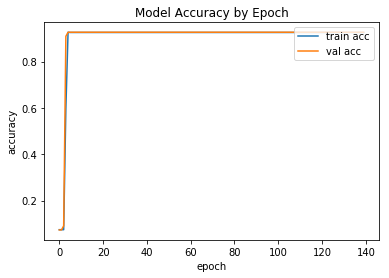

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy by Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper right')
plt.show()

In [0]:
#5/3/1 스케일링 한 쪽만
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy by Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')
plt.show()

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 2)                 22        
_________________________________________________________________
dense_65 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 3         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
#y_train = keras.utils.to_categorical(y_train, 3) #
#y_test = keras.utils.to_categorical(y_test, 3) #
#print("훈련 데이터 : \n{} ".format(y_train))
#print("테스트 데이터: \n{} ".format(y_test))

In [0]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('')
print('loss : ' + str(loss_and_metrics[0]))
print('accuray : ' + str(loss_and_metrics[1]))

285/285 [==============================] - 0s 64us/step

loss : 0.3208687429888207
accuray : 0.9263157898919624


In [0]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(x_test)
#print(y_pred)

In [0]:
con_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix : \n {}".format(con_matrix))

Confusion Matrix : 
 [[264   0]
 [ 21   0]]


### 휴지통 

#### Min Max Scaling (need?)

In [0]:
# Min Max scale

scaler=MinMaxScaler()

df[['rent/cradle','return/cradle']]=scaler.fit_transform(df[['rent/cradle','return/cradle']])
#df.head()

,CONTENT_ID,Date,rent_num,return_num,ADDR_GU,CRADLE_COUNT,LATITUDE,LONGITUDE,RENT_ID,rent/cradle,return/cradle
0,201,2015-09-19,11,19,영등포구,15.0,37.531239,126.921333,ST-46,0.001632,0.002537
1,131,2015-09-19,5,7,서대문구,23.0,37.584171,126.911102,ST-33,0.000484,0.000610
2,124,2015-09-19,15,14,마포구,20.0,37.551140,126.936989,ST-26,0.001669,0.001402
3,135,2015-09-19,6,4,서대문구,10.0,37.559101,126.939178,ST-37,0.001335,0.000801
4,217,2015-09-19,9,6,영등포구,10.0,37.522079,126.930367,ST-66,0.002003,0.001202


####설과 추석 및 기타 공휴일?

In [0]:
!pip install pytimekr

from pytimekr import pytimekr

In [0]:
chuseok = [pytimekr.chuseok(x) for x in [2015,2016,2017,2018]]
chuseok_red = [pytimekr.red_days(x) for x in chuseok]
ly = [pytimekr.lunar_newyear(x) for x in [2016,2017,2018]]
ly_red = [pytimekr.red_days(x) for x in ly]
print (chuseok_red)
print (ly_red)

[[datetime.date(2015, 9, 26), datetime.date(2015, 9, 27), datetime.date(2015, 9, 28)], [datetime.date(2016, 9, 14), datetime.date(2016, 9, 15), datetime.date(2016, 9, 16)], [datetime.date(2017, 10, 3), datetime.date(2017, 10, 4), datetime.date(2017, 10, 5)], [datetime.date(2018, 9, 23), datetime.date(2018, 9, 24), datetime.date(2018, 9, 25)]]
[[datetime.date(2016, 2, 7), datetime.date(2016, 2, 8), datetime.date(2016, 2, 9)], [datetime.date(2017, 1, 27), datetime.date(2017, 1, 28), datetime.date(2017, 1, 29)], [datetime.date(2018, 2, 15), datetime.date(2018, 2, 16), datetime.date(2018, 2, 17)]]


In [0]:
type(ly_red[0][0])

datetime.date

#### 휴지통

In [0]:
station_list=subway['STATION_CD'].tolist()
station_list.remove('102C')

In [0]:
# plt.figure(3)
# plt.scatter((rental['day_return']),rental['day_rent'],marker='o',label='weekday_corr')
# #x = np.linspace(*ax.get_xlim())
# #plt.plot(x,x)
# plt.xlabel('return')
# plt.ylabel('rent')
# plt.legend()

In [0]:
X=pd.DataFrame(rental['day_return'])
y=rental['day_rent']
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
model=reg.fit(X,y)
model.coef_
# model.intercept_

array([0.92026668])

In [0]:
rental[rental["CRADLE_COUNT"]<10]

,ADDR_GU,CONTENT_ID,CRADLE_COUNT,LATITUDE,LONGITUDE,RENT_ID,day_rent,day_return
30,강남구,2332,8.0,37.504208,127.048965,ST-815,14.994329,14.546314
49,강남구,2354,5.0,37.519787,127.056763,ST-953,4.857456,3.967105
71,강남구,2381,8.0,37.506367,127.034523,ST-1246,7.554113,7.333333
132,강동구,1039,7.0,37.561279,127.167801,ST-1056,2.802778,3.147222
143,강동구,1053,8.0,37.562538,127.164528,ST-1594,4.892857,6.654762
149,강동구,1060,8.0,37.544659,127.132637,ST-1620,9.587500,9.662500
152,강북구,1501,9.0,37.626080,127.026482,ST-948,13.658385,14.213251
158,강북구,1511,9.0,37.631123,127.036034,ST-861,3.241237,3.435052
169,강북구,1526,8.0,37.641739,127.024628,ST-1100,6.498638,5.980926
181,강북구,1538,8.0,37.656158,127.013138,ST-1388,8.276596,8.897872


In [0]:
#bok1.index = np.arange(0, len(bok1))
# def get(api_name,api_key,end_index=None):
  
#   url=url_format.format(api_name=api_name,api_key=api_key,end_index=1)
#   response=requests.get(url)
#   print(response.json())
  
#get(api_name="PublicBicycleRenTIdinfo",api_key=Big.api_key
    
response=requests.get("http://openapi.seoul.go.kr:8088/4766464f6867693836337476594649/json/PublicBicycleRenTIdinfo/5/6/")
response.json()["PublicBicycleRenTIdinfo"]

#     result=pd.DataFrame(response[api_name]["row"])
    
#     for count in range(end_index1):
#       url=self.url_format.format(api_name=api_name,api_key=api_key, end_index=count)
#       response = requests.get(url).json()
#       re
    
#     url=self.url_format.format(api_name=api_name,api_key=api_key,end_index=end_index1)
#     response1=requests.get(url)
    
#     print(response1.json())
#     #result=pd.DataFrame(response1.json()[api_name]["row"])
    
    
#     for count in range(end_index1):
#       url=self.url_format.format(api_name=api_name,api_key=api_key, end_index=count)
#       response=requests.get(url)
#       print(response)
#       #print(response.json()[api_name]["row"])


#########################################
#   def get(self,api_name,api_key,start_index=None,end_index=None):
#     url=self.url_format.format(api_name=api_name,api_key=api_key,start_index=1, end_index=1)
#     re = requests.get(url).json()
#     end_index1 = re[api_name]["list_total_count"]
#     print("Max Count(%s)"%(end_index1))
    
#     if end_index1>1000 & end_index1<2000:
#       print("Max Count is (%s). Need split"%(end_index1))
#       url=self.url_format.format(api_name=api_name,api_key=api_key,start_index=1, end_index=1000)
#       response1 = requests.get(url).json()
#       result1=pd.DataFrame(response1[api_name]["row"])
      
#       url=self.url_format.format(api_name=api_name,api_key=api_key,start_index=1001, end_index=end_index1)
#       response2 = requests.get(url).json()
#       result2=pd.DataFrame(response2[api_name]["row"])
#     elif end_index<1000 or end_index1>2000:
#       print("index size error")      
    
#     return result1,result2

In [0]:
type(df["Date"][1])

pandas._libs.tslibs.timestamps.Timestamp

In [0]:
sample_108=df_day.loc[df_day["CONTENT_ID"]==108,:]
len(sample_108)

808

In [0]:
sample_108.head()

,CONTENT_ID,Date,rent_num,return_num,ADDR_GU,CRADLE_COUNT,LATITUDE,LONGITUDE,RENT_ID,rent/cradle,return/cradle,day_of_the_week
119,108,2015-09-21,11,11,마포구,10.0,37.552746,126.918617,ST-10,0.002448,0.002204,Monday
232,108,2015-09-22,12,6,마포구,10.0,37.552746,126.918617,ST-10,0.002670,0.001202,Tuesday
283,108,2015-09-23,6,3,마포구,10.0,37.552746,126.918617,ST-10,0.001335,0.000601,Wednesday
336,108,2015-09-24,5,7,마포구,10.0,37.552746,126.918617,ST-10,0.001113,0.001402,Thursday
367,108,2015-09-25,9,11,마포구,10.0,37.552746,126.918617,ST-10,0.002003,0.002204,Friday


In [0]:
list_of_df_day[0][1]["rent/cradle"].sum()

4.730307076101468

In [0]:
# 분모의 날짜 수
a=dictday[2301]["Date"].tolist()[0]
b=dictday[2301]["Date"].tolist()[-1]
aa=datetime.date(a)
bb=datetime.date(b)
diff=bb-aa
print(diff.days)

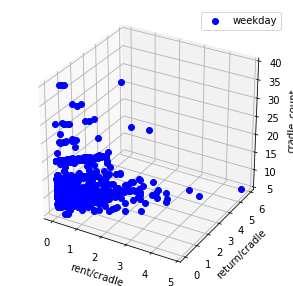

In [0]:
#평일만 실행 시켜 보았음.

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure(figsize=(5,5))

ax=fig.gca(projection='3d')
#rent/cradle	return/cradle
x=rental['day_rent/cradle']
y=rental['day_return/cradle']
z=rental['CRADLE_COUNT']

ax.plot(x,y,z,'bo')

ax.set_xlabel('rent/cradle')
ax.set_ylabel('return/cradle')
ax.set_zlabel('cradle_count')

plt.legend(loc='upper right',labels=['weekday','weekend'])

plt.show()

In [0]:
# fig=plt.figure(figsize=(8,8))

# ax=fig.gca(projection='3d')

# x=df_day1['rent/ncradle']
# y=df_day1['retrun/ncradle']
# z=df_day1['CRADLE_COUNT']

# xx=df_end1['rent/ncradle']
# yy=df_end1['retrun/ncradle']
# zz=df_end1['CRADLE_COUNT']

# ax.plot(x,y,z,'bo')
# ax.plot(xx,yy,zz,'ro')

# ax.set_xlabel('rent_num/cradle')
# ax.set_ylabel('return_num/cradle')
# ax.set_zlabel('cradle_count')

# plt.legend(loc='upper right',labels=['weekday','weekend'])


# plt.show()

In [0]:
import folium
a=[37.5298942,126.9625863] #[위도 값, 경도 값]
map =folium.Map(location=a, zoom_start=0)#location은 맵을 열었을 때 처음 보이는 위치, 즉 시작 위치; zoom_start는 숫자가 커질수록 맵이 확대되어 보인다.
folium.Marker(location=a,popup="Marker",icon=folium.Icon(color="red")).add_to(map)
#map

In [0]:
np.min(dist_bustop.iloc[:,1:2])

(37.524071, 127.02179)    0.088135
dtype: float64

In [0]:
#ubway.apply(lambda x:Big.get3(api_name="SearchLocationOfSTNByIDService",sub_key=x['STATION_CD']),axis=1)

df2 = bus_col.join(pd.DataFrame(bus_col.inde.str.split(',').tolist(),columns=['LATITUDE', 'LONGITUDE',]))
df2 = df2.applymap(lambda x: x.strip())

AttributeError: ignored

In [0]:
import scipy as sp
import seaborn as sns
mu = 0
std = 1
rv = sp.stats.norm(mu, std)
xx = np.linspace(-5, 5, 100)
plt.plot(xx, rv.pdf(xx))

sns.distplot(rental.iloc[:,9])

rental['std_re_cradle'].plot.kde()
plt.show()

In [0]:
# extracting tuples of list
# harv_=[{'rental_info':rental_info},{'bus_stop':bus_stop},{'subb':subb},{'doro':doro},{'jandi':jandi}]
# for info in harv_:
#   '{}_subset'.format(info[''=info[['LATITUDE', 'LONGITUDE']].apply(pd.to_numeric)
#   '{}_location'.format(info) = [tuple(x) for x in '{}_subset'.format(info).values]

#### 실시간 정보 바탕

In [0]:
bikelist=bikelist.rename({'stationLatitude':'LATITUDE','stationLongitude':'LONGITUDE'},axis=1)

In [0]:
bikelist.loc[bikelist['shared'] <=100,'target'] = 0
bikelist.loc[bikelist['shared'] >150,'target'] = 1
#bikelist.loc[bikelist['shared'] <50,'target'] = -1
target_num=len(bikelist[abs(bikelist.target)==1])
print("There are {target_nums} targets.".format(target_nums=target_num))
print("Unnecessary cradle count is {a}. Too many return, deficient cradle count is {b}".format(a=len(bikelist[bikelist.target==-1]), b=len(bikelist[bikelist.target==1])))

There are 127 targets.
Unnecessary cradle count is 0. Too many return, deficient cradle count is 127


In [0]:
real_time=bikelist[bikelist["shared"]>150]
real_time.head()

,parkingBikeTotCnt,rackTotCnt,shared,stationId,LATITUDE,LONGITUDE,stationName,target
4,24,10,240,ST-1042,37.546841,127.172516,1025.0,1.0
26,23,15,153,ST-1421,37.554829,127.137321,1051.0,1.0
34,13,8,163,ST-1620,37.544659,127.132637,1060.0,1.0
45,26,10,260,ST-1062,37.561550,126.810478,1150.0,1.0
49,18,10,180,ST-1067,37.569260,126.848419,1155.0,1.0


In [0]:
from folium.plugins import FastMarkerCluster
map_seoul2=folium.Map(location=[37.5662952,126.9779451], zoom_start=12.1,tiles="Stamen Toner")

lati=real_time['LATITUDE'].tolist()
long=real_time['LONGITUDE'].tolist()

feature_group = folium.FeatureGroup("Location")

for lat, lng in zip(lati,long):
  feature_group.add_child(folium.Marker(location=[lat,lng],popup="Marker"))

map_seoul2.add_child(feature_group)  
#good=rental[rental.target==0]
#map_seoul1.add_child(FastMarkerCluster(good[['LATITUDE','LONGITUDE']].values.tolist()))

map_seoul2